In [2]:
from __future__ import absolute_import, division
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
from trainingUtils import MultipleOptimizer, MultipleScheduler, compute_kernel, compute_mmd
from models import Encoder,Decoder,GaussianDecoder,VAE,CellStateEncoder,\
                   CellStateDecoder, CellStateVAE,\
                   SimpleEncoder,LocalDiscriminator,PriorDiscriminator,\
                   EmbInfomax,MultiEncInfomax,Classifier,\
                   SpeciesCovariate,GaussianDecoder
# import argparse
import math
import numpy as np
import pandas as pd
import sys
import random
import os
from IPython.display import clear_output
from matplotlib import pyplot as plt

#from scipy.stats import pearsonr
from sklearn.metrics import silhouette_score,confusion_matrix
from scipy.stats import spearmanr
from evaluationUtils import r_square,get_cindex,pearson_r,pseudoAccuracy
import seaborn as sns
sns.set()

In [3]:
device = torch.device('cuda')

In [4]:
# Initialize environment and seeds for reproducability
torch.backends.cudnn.benchmark = True


def seed_everything(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.benchmark = False
    
# Read data
cmap = pd.read_csv('../preprocessing/preprocessed_data/cmap_landmarks_HT29_A375.csv',index_col = 0)
# cmap = pd.read_csv('../preprocessing/preprocessed_data/cmap_landmarks_HA1E_PC3.csv',index_col = 0)
#cmap = pd.read_csv('../preprocessing/preprocessed_data/cmap_HT29_A375.csv',index_col = 0)
#cmap_tf = pd.read_csv('../../../L1000_2021_11_23/cmap_compounds_tfs_repq1_tas03.tsv',
#                       sep='\t', low_memory=False, index_col=0)

gene_size = len(cmap.columns)
samples = cmap.index.values
# gene_size = len(cmap_tf.columns)
# samples = cmap_tf.index.values

# sampleInfo = pd.read_csv('../preprocessing/preprocessed_data/conditions_HT29_A375.csv',index_col = 0)

In [5]:
# Create a train generators
def getSamples(N, batchSize):
    order = np.random.permutation(N)
    outList = []
    while len(order)>0:
        outList.append(order[0:batchSize])
        order = order[batchSize:]
    return outList

# Train model

In [6]:
model_params = {'encoder_1_hiddens':[640,384],
                'encoder_2_hiddens':[640,384],
                'latent_dim': 292,
                'decoder_1_hiddens':[384,640],
                'decoder_2_hiddens':[384,640],
                'dropout_decoder':0.2,
                'dropout_encoder':0.1,
                'encoder_activation':torch.nn.ELU(),
                'decoder_activation':torch.nn.ELU(),
                'V_dropout':0.25,
                'state_class_hidden':[256,128,64],
                'state_class_drop_in':0.5,
                'state_class_drop':0.25,
                'no_states':2,
                'adv_class_hidden':[256,128,64],
                'adv_class_drop_in':0.3,
                'adv_class_drop':0.1,
                'no_adv_class':2,
                'encoding_lr':0.001,
                'adv_lr':0.001,
                'schedule_step_adv':200,
                'gamma_adv':0.5,
                'schedule_step_enc':200,
                'gamma_enc':0.8,
                'batch_size_1':178,
                'batch_size_2':154,
                'batch_size_paired':90,
                'epochs':1000,
                'prior_beta':1.0,
                'no_folds':10,
                'v_reg':1e-04,
                'state_class_reg':1e-02,
                'enc_l2_reg':0.01,
                'dec_l2_reg':0.01,
                'lambda_mi_loss':100,
                'effsize_reg': 100,
                'cosine_loss': 10,
                'adv_penalnty':100,
                'reg_adv':1000,
                'reg_classifier': 1000,
                'similarity_reg' : 10,
                'adversary_steps':4,
                'autoencoder_wd': 0.,
                'adversary_wd': 0.}

### Pre-train encoder and then classifier to have apre-trained discriminator

In [7]:
# class_criterion = torch.nn.CrossEntropyLoss()
# NUM_EPOCHS= 2000
# #bs = 512
# bs_1 = model_params['batch_size_1']
# bs_2 =  model_params['batch_size_2']
# bs_paired =  model_params['batch_size_paired']

In [8]:
# for i in range(10):
#     # Network
#     encoder = SimpleEncoder(gene_size,model_params['encoder_1_hiddens'],model_params['latent_dim'],
#                               dropRate=model_params['dropout_encoder'], 
#                               activation=model_params['encoder_activation']).to(device)
#     prior_d = PriorDiscriminator(model_params['latent_dim']).to(device)
#     local_d = LocalDiscriminator(model_params['latent_dim'],model_params['latent_dim']).to(device)
    
#     adverse_classifier = Classifier(in_channel=model_params['latent_dim'],
#                                     hidden_layers=model_params['adv_class_hidden'],
#                                     num_classes=model_params['no_adv_class'],
#                                     drop_in=0.5,
#                                     drop=0.3).to(device)
    
#     trainInfo_paired = pd.read_csv('10fold_validation_spit/train_paired_%s.csv'%i,index_col=0)
#     trainInfo_1 = pd.read_csv('10fold_validation_spit/train_a375_%s.csv'%i,index_col=0)
#     trainInfo_2 = pd.read_csv('10fold_validation_spit/train_ht29_%s.csv'%i,index_col=0)
    
#     valInfo_paired = pd.read_csv('10fold_validation_spit/val_paired_%s.csv'%i,index_col=0)
#     valInfo_1 = pd.read_csv('10fold_validation_spit/val_a375_%s.csv'%i,index_col=0)
#     valInfo_2 = pd.read_csv('10fold_validation_spit/val_ht29_%s.csv'%i,index_col=0)
    
#     N_paired = len(trainInfo_paired)
#     N_1 = len(trainInfo_1)
#     N_2 = len(trainInfo_2)
#     N = N_1
#     if N_2>N:
#         N=N_2
    
#     allParams = list(encoder.parameters())
#     allParams = allParams + list(prior_d.parameters()) + list(local_d.parameters())
#     allParams = allParams + list(adverse_classifier.parameters())
#     optimizer = torch.optim.Adam(allParams, lr= model_params['encoding_lr'], weight_decay=0)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                 step_size=model_params['schedule_step_enc'],
#                                                 gamma=model_params['gamma_enc'])
#     for e in range(0, NUM_EPOCHS):
#         encoder.train()
#         prior_d.train()
#         local_d.train()
#         adverse_classifier.train()
        
#         trainloader_1 = getSamples(N_1, bs_1)
#         len_1 = len(trainloader_1)
#         trainloader_2 = getSamples(N_2, bs_2)
#         len_2 = len(trainloader_2)
#         trainloader_paired = getSamples(N_paired, bs_paired)
#         len_paired = len(trainloader_paired)

#         lens = [len_1,len_2,len_paired]
#         maxLen = np.max(lens)
        
#         if maxLen>lens[0]:
#             trainloader_suppl = getSamples(N_1, bs_1)
#             for jj in range(maxLen-lens[0]):
#                 trainloader_1.insert(jj,trainloader_suppl[jj])
        
#         if maxLen>lens[1]:
#             trainloader_suppl = getSamples(N_2, bs_2)
#             for jj in range(maxLen-lens[1]):
#                 trainloader_2.insert(jj,trainloader_suppl[jj])
        
#         if maxLen>lens[2]:
#             trainloader_suppl = getSamples(N_paired, bs_paired)
#             for jj in range(maxLen-lens[2]):
#                 trainloader_paired.insert(jj,trainloader_suppl[jj])
        
#         for j in range(maxLen):
#             dataIndex_1 = trainloader_1[j]
#             dataIndex_2 = trainloader_2[j]
#             dataIndex_paired = trainloader_paired[j]
            
#             df_pairs = trainInfo_paired.iloc[dataIndex_paired,:]
#             df_1 = trainInfo_1.iloc[dataIndex_1,:]
#             df_2 = trainInfo_2.iloc[dataIndex_2,:]
#             paired_inds = len(df_pairs)
            
            
#             X_1 = torch.tensor(np.concatenate((cmap.loc[df_pairs['sig_id.x']].values,
#                                                  cmap.loc[df_1.sig_id].values))).float().to(device)
#             X_2 = torch.tensor(np.concatenate((cmap.loc[df_pairs['sig_id.y']].values,
#                                                  cmap.loc[df_2.sig_id].values))).float().to(device)
            
            
#             conditions = np.concatenate((df_pairs.conditionId.values,
#                                          df_1.conditionId.values,
#                                          df_pairs.conditionId.values,
#                                          df_2.conditionId.values))
#             size = conditions.size
#             conditions = conditions.reshape(size,1)
#             conditions = conditions == conditions.transpose()
#             conditions = conditions*1
#             mask = torch.tensor(conditions).to(device).detach()
#             pos_mask = mask
#             neg_mask = 1 - mask
#             log_2 = math.log(2.)
#             optimizer.zero_grad()
                        
#             #if iteration % model_params["adversary_steps"] == 0:            
#             z_1 = encoder(X_1)
#             z_2 = encoder(X_2)
#             latent_vectors = torch.cat((z_1, z_2), 0)
#             labels_adv = adverse_classifier(latent_vectors)
#             true_labels = torch.cat((torch.ones(z_1.shape[0]),
#                                      torch.zeros(z_2.shape[0])),0).long().to(device)
#             adv_entropy = class_criterion(labels_adv,true_labels)
#             _, predicted = torch.max(labels_adv, 1)
#             predicted = predicted.cpu().numpy()
#             cf_matrix = confusion_matrix(true_labels.cpu().numpy(),predicted)
#             tn, fp, fn, tp = cf_matrix.ravel()
#             f1 = 2*tp/(2*tp+fp+fn)
            
            
#             #z_un = local_d(torch.cat((z_1, z_2), 0))
#             z_un = local_d(latent_vectors)
#             res_un = torch.matmul(z_un, z_un.t())
            
#             p_samples = res_un * pos_mask.float()
#             q_samples = res_un * neg_mask.float()

#             Ep = log_2 - F.softplus(- p_samples)
#             Eq = F.softplus(-q_samples) + q_samples - log_2

#             Ep = (Ep * pos_mask.float()).sum() / pos_mask.float().sum()
#             Eq = (Eq * neg_mask.float()).sum() / neg_mask.float().sum()
#             mi_loss = Eq - Ep

#             #prior = torch.rand_like(torch.cat((z_1, z_2), 0))
#             prior = torch.rand_like(latent_vectors)

#             term_a = torch.log(prior_d(prior)).mean()
#             term_b = torch.log(1.0 - prior_d(latent_vectors)).mean()
#             prior_loss = -(term_a + term_b) * model_params['prior_beta']
            
#             # Remove signal from z_basal
#             loss = mi_loss + prior_loss + adv_entropy +\
#                    adverse_classifier.L2Regularization(model_params['state_class_reg']) +\
#                    encoder.L2Regularization(model_params['enc_l2_reg'])
                   

#             loss.backward()
#             optimizer.step()
            
#         scheduler.step()
#         outString = 'Split {:.0f}: Epoch={:.0f}/{:.0f}'.format(i+1,e+1,NUM_EPOCHS)
#         outString += ', MI Loss={:.4f}'.format(mi_loss.item())
#         outString += ', Prior Loss={:.4f}'.format(prior_loss.item())
#         outString += ', Entropy Loss={:.4f}'.format(adv_entropy.item())
#         outString += ', loss={:.4f}'.format(loss.item())
#         outString += ', F1 score={:.4f}'.format(f1)
#         if (e%250==0):
#             print(outString)
#     print(outString)
#     encoder.eval()
#     prior_d.eval()
#     local_d.eval()
#     adverse_classifier.eval()
    
#     paired_val_inds = len(valInfo_paired)
#     x_1 = torch.tensor(np.concatenate((cmap.loc[valInfo_paired['sig_id.x']].values,
#                                           cmap.loc[valInfo_1.sig_id].values))).float().to(device)
#     x_2 = torch.tensor(np.concatenate((cmap.loc[valInfo_paired['sig_id.y']].values,
#                                           cmap.loc[valInfo_2.sig_id].values))).float().to(device)
    
    
#     z_latent_1 = encoder(x_1)
#     z_latent_2 = encoder(x_2)
    
    
#     labels = adverse_classifier(torch.cat((z_latent_1, z_latent_2), 0))
#     true_labels = torch.cat((torch.ones(z_latent_1.shape[0]).view(z_latent_1.shape[0],1),
#                              torch.zeros(z_latent_2.shape[0]).view(z_latent_2.shape[0],1)),0).long()
#     _, predicted = torch.max(labels, 1)
#     predicted = predicted.cpu().numpy()
#     cf_matrix = confusion_matrix(true_labels.numpy(),predicted)
#     tn, fp, fn, tp = cf_matrix.ravel()
#     class_acc = (tp+tn)/predicted.size
#     f1 = 2*tp/(2*tp+fp+fn)
        
#     print('Classification accuracy: %s'%class_acc)
#     print('Classification F1 score: %s'%f1)
    
#     torch.save(encoder,'../results/MI_results/models/CPA_approach/pre_trained_master_encoder_%s.pt'%i)
#     torch.save(adverse_classifier,'../results/MI_results/models/CPA_approach/pre_trained_classifier_adverse_%s.pt'%i)

### Train the whole model

In [9]:
def compute_gradients(output, input):
    grads = torch.autograd.grad(output, input, create_graph=True)
    grads = grads[0].pow(2).mean()
    return grads

In [10]:
class_criterion = torch.nn.CrossEntropyLoss()
NUM_EPOCHS= model_params['epochs']
#bs = 512
bs_1 = model_params['batch_size_1']
bs_2 =  model_params['batch_size_2']
bs_paired =  model_params['batch_size_paired']

In [10]:
# NUM_EPOCHS = 300
# #bs = 128
# bs_a375 = 45
# bs_ht29 = 39
# bs_paired = 22
# beta = 1.0

In [ ]:
valR2 = []
valPear = []
valMSE =[]
valSpear = []
valAccuracy = []


valPearDirect = []
valSpearDirect = []
valAccDirect = []

valR2_1 = []
valPear_1 = []
valMSE_1 =[]
valSpear_1 = []
valAccuracy_1 = []

valR2_2 = []
valPear_2 = []
valMSE_2 =[]
valSpear_2 = []
valAccuracy_2 = []

crossCorrelation = []

valF1 = []
valClassAcc = []

for i in range(10):
    # Network
    #encoder = torch.load('../results/MI_results/models/CPA_approach/pre_trained_master_encoder_2.pt')
    #master_encoder = SimpleEncoder(gene_size,[640,384],292,dropRate=0.1, activation=torch.nn.ELU())#.to(device)
    decoder_1 = Decoder(model_params['latent_dim'],model_params['decoder_1_hiddens'],gene_size,
                        dropRate=model_params['dropout_decoder'], 
                        activation=model_params['decoder_activation']).to(device)
    decoder_2 = Decoder(model_params['latent_dim'],model_params['decoder_2_hiddens'],gene_size,
                        dropRate=model_params['dropout_decoder'], 
                        activation=model_params['decoder_activation']).to(device)
    encoder_1 = SimpleEncoder(gene_size,model_params['encoder_1_hiddens'],model_params['latent_dim'],
                              dropRate=model_params['dropout_encoder'], 
                              activation=model_params['encoder_activation']).to(device)
    #encoder_1.load_state_dict(encoder.state_dict())
    encoder_2 = SimpleEncoder(gene_size,model_params['encoder_2_hiddens'],model_params['latent_dim'],
                                  dropRate=model_params['dropout_encoder'], 
                                  activation=model_params['encoder_activation']).to(device)
    #encoder_2.load_state_dict(encoder.state_dict())
    prior_d = PriorDiscriminator(model_params['latent_dim']).to(device)
    local_d = LocalDiscriminator(model_params['latent_dim'],model_params['latent_dim']).to(device)
    
    classifier = Classifier(in_channel=model_params['latent_dim'],
                            hidden_layers=model_params['state_class_hidden'],
                            num_classes=model_params['no_states'],
                            drop_in=model_params['state_class_drop_in'],
                            drop=model_params['state_class_drop']).to(device)
    adverse_classifier = Classifier(in_channel=model_params['latent_dim'],
                                    hidden_layers=model_params['adv_class_hidden'],
                                    num_classes=model_params['no_adv_class'],
                                    drop_in=model_params['adv_class_drop_in'],
                                    drop=model_params['adv_class_drop']).to(device)
    pretrained_adv_class = torch.load('../results/MI_results/models/CPA_approach/pre_trained_classifier_adverse_0.pt')
    adverse_classifier.load_state_dict(pretrained_adv_class.state_dict())
    
    Vsp = SpeciesCovariate(2,model_params['latent_dim'],dropRate=model_params['V_dropout']).to(device)
    
    trainInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_paired_%s.csv'%i,index_col=0)
    trainInfo_1 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_a375_%s.csv'%i,index_col=0)
    trainInfo_2 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_ht29_%s.csv'%i,index_col=0)
    
    valInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_paired_%s.csv'%i,index_col=0)
    valInfo_1 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_a375_%s.csv'%i,index_col=0)
    valInfo_2 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_ht29_%s.csv'%i,index_col=0)

    #trainInfo_2 = pd.concat((trainInfo_2,
    #                         valInfo_2,
    #                         valInfo_paired.loc[:,['sig_id.y','cell_iname.y','conditionId']].rename(columns = {'sig_id.y':'sig_id','cell_iname.y':'cell_iname'})),0)
    
    N_paired = len(trainInfo_paired)
    N_1 = len(trainInfo_1)
    N_2 = len(trainInfo_2)
    N = N_1
    if N_2>N:
        N=N_2
    
    allParams = list(decoder_1.parameters()) +list(decoder_2.parameters())
    allParams = allParams + list(encoder_1.parameters()) +list(encoder_2.parameters())
    allParams = allParams + list(prior_d.parameters()) + list(local_d.parameters())
    allParams = allParams + list(classifier.parameters())
    allParams = allParams + list(Vsp.parameters())
    optimizer = torch.optim.Adam(allParams, lr= model_params['encoding_lr'],
                                 weight_decay=model_params['autoencoder_wd'])
    optimizer_adv = torch.optim.Adam(adverse_classifier.parameters(), lr= model_params['adv_lr'], 
                                     weight_decay=model_params['adversary_wd'])
    if model_params['schedule_step_adv'] is not None:
        scheduler_adv = torch.optim.lr_scheduler.StepLR(optimizer_adv,
                                                        step_size=model_params['schedule_step_adv'],
                                                        gamma=model_params['gamma_adv'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=model_params['schedule_step_enc'],
                                                gamma=model_params['gamma_enc'])
    iteration = 1
    for e in range(0, NUM_EPOCHS):
        decoder_1.train()
        decoder_2.train()
        encoder_1.train()
        encoder_2.train()
        prior_d.train()
        local_d.train()
        classifier.train()
        adverse_classifier.train()
        Vsp.train()
        #master_encoder.train()
        
        trainloader_1 = getSamples(N_1, bs_1)
        len_1 = len(trainloader_1)
        trainloader_2 = getSamples(N_2, bs_2)
        len_2 = len(trainloader_2)
        trainloader_paired = getSamples(N_paired, bs_paired)
        len_paired = len(trainloader_paired)

        lens = [len_1,len_2,len_paired]
        maxLen = np.max(lens)
        
        iteration = 1

        if maxLen>lens[0]:
            trainloader_suppl = getSamples(N_1, bs_1)
            for jj in range(maxLen-lens[0]):
                trainloader_1.insert(jj,trainloader_suppl[jj])
        
        if maxLen>lens[1]:
            trainloader_suppl = getSamples(N_2, bs_2)
            for jj in range(maxLen-lens[1]):
                trainloader_2.insert(jj,trainloader_suppl[jj])
        
        if maxLen>lens[2]:
            trainloader_suppl = getSamples(N_paired, bs_paired)
            for jj in range(maxLen-lens[2]):
                trainloader_paired.insert(jj,trainloader_suppl[jj])
        #for dataIndex in trainloader:
        for j in range(maxLen):
            dataIndex_1 = trainloader_1[j]
            dataIndex_2 = trainloader_2[j]
            dataIndex_paired = trainloader_paired[j]
            
            df_pairs = trainInfo_paired.iloc[dataIndex_paired,:]
            df_1 = trainInfo_1.iloc[dataIndex_1,:]
            df_2 = trainInfo_2.iloc[dataIndex_2,:]
            paired_inds = len(df_pairs)
            
            
            X_1 = torch.tensor(np.concatenate((cmap.loc[df_pairs['sig_id.x']].values,
                                                 cmap.loc[df_1.sig_id].values))).float().to(device)
            X_2 = torch.tensor(np.concatenate((cmap.loc[df_pairs['sig_id.y']].values,
                                                 cmap.loc[df_2.sig_id].values))).float().to(device)
            
            z_species_1 = torch.cat((torch.ones(X_1.shape[0],1),
                                     torch.zeros(X_1.shape[0],1)),1).to(device)
            z_species_2 = torch.cat((torch.zeros(X_2.shape[0],1),
                                     torch.ones(X_2.shape[0],1)),1).to(device)
            
            
            conditions = np.concatenate((df_pairs.conditionId.values,
                                         df_1.conditionId.values,
                                         df_pairs.conditionId.values,
                                         df_2.conditionId.values))
            size = conditions.size
            conditions = conditions.reshape(size,1)
            conditions = conditions == conditions.transpose()
            conditions = conditions*1
            mask = torch.tensor(conditions).to(device).detach()
            pos_mask = mask
            neg_mask = 1 - mask
            log_2 = math.log(2.)
            optimizer.zero_grad()
            optimizer_adv.zero_grad()
                        
            #if e % model_params['adversary_steps']==0:      
            z_base_1 = encoder_1(X_1)
            z_base_2 = encoder_2(X_2)
            latent_base_vectors = torch.cat((z_base_1, z_base_2), 0)
            labels_adv = adverse_classifier(latent_base_vectors)
            true_labels = torch.cat((torch.ones(z_base_1.shape[0]),
                                         torch.zeros(z_base_2.shape[0])),0).long().to(device)
            _, predicted = torch.max(labels_adv, 1)
            predicted = predicted.cpu().numpy()
            cf_matrix = confusion_matrix(true_labels.cpu().numpy(),predicted)
            tn, fp, fn, tp = cf_matrix.ravel()
            f1_basal_trained = 2*tp/(2*tp+fp+fn)
            adv_entropy = class_criterion(labels_adv,true_labels)
            adversary_drugs_penalty = compute_gradients(labels_adv.sum(), latent_base_vectors)
            loss_adv = adv_entropy + model_params['adv_penalnty'] * adversary_drugs_penalty
            loss_adv.backward()
            optimizer_adv.step()
            #else:
            optimizer.zero_grad()
            #f1_basal_trained = None
            z_base_1 = encoder_1(X_1)
            z_base_2 = encoder_2(X_2)
            latent_base_vectors = torch.cat((z_base_1, z_base_2), 0)
            
            #z_un = local_d(torch.cat((z_1, z_2), 0))
            z_un = local_d(latent_base_vectors)
            res_un = torch.matmul(z_un, z_un.t())
            
            z_1 = Vsp(z_base_1,z_species_1)
            z_2 = Vsp(z_base_2,z_species_2)
            latent_vectors = torch.cat((z_1, z_2), 0)
            
            y_pred_1 = decoder_1(z_1)
            fitLoss_1 = torch.mean(torch.sum((y_pred_1 - X_1)**2,dim=1))
            L2Loss_1 = decoder_1.L2Regularization(model_params['dec_l2_reg']) + encoder_1.L2Regularization(model_params['enc_l2_reg'])
            loss_1 = fitLoss_1 + L2Loss_1
            
            y_pred_2 = decoder_2(z_2)
            fitLoss_2 = torch.mean(torch.sum((y_pred_2 - X_2)**2,dim=1))
            L2Loss_2 = decoder_2.L2Regularization(model_params['dec_l2_reg']) + encoder_2.L2Regularization(model_params['enc_l2_reg'])
            loss_2 = fitLoss_2 + L2Loss_2

            #silimalityLoss = np.sqrt(paired_inds)*torch.mean(torch.sum((z_base_1[0:paired_inds,:] - z_base_2[0:paired_inds,:])**2,
            #                                      dim=-1))/torch.std(torch.sum((z_base_1[0:paired_inds,:] - z_base_2[0:paired_inds,:])**2,
            #                                                                   dim=-1))
            silimalityLoss = torch.mean(torch.sum((z_base_1[0:paired_inds,:] - z_base_2[0:paired_inds,:])**2,dim=-1))
            #NN1 = z_base_1[paired_inds:,:].shape[0]
            #NN2 = z_base_2[paired_inds:,:].shape[0]
            #if NN1>NN2:
            #    n1 = NN2
            #else:
            #    n1 = NN1
            #effect_size = torch.mean(torch.sum((z_base_1[paired_inds:(paired_inds+n1),:].detach() - z_base_2[paired_inds:(paired_inds+n1),:].detach())**2,dim=-1)).detach() - silimalityLoss.detach()
            #s1 = torch.std(torch.sum((z_base_1[paired_inds:(paired_inds+n1),:].detach() - z_base_2[paired_inds:(paired_inds+n1),:].detach())**2,dim=-1)).detach()
            #s2 = torch.std(torch.sum((z_base_1[0:paired_inds,:].detach() - z_base_2[0:paired_inds,:].detach())**2,dim=-1)).detach()
            #n2 = paired_inds
            #s_pooled = torch.sqrt(((n1-1)* s1**2 + (n2-1)* s2**2)/(n1+n2-2)).detach()
            #effect_size = effect_size/s_pooled
            cosineLoss = torch.nn.functional.cosine_similarity(z_base_1[0:paired_inds,:],z_base_2[0:paired_inds,:],dim=-1).mean()
            
            p_samples = res_un * pos_mask.float()
            q_samples = res_un * neg_mask.float()
    
            Ep = log_2 - F.softplus(- p_samples)
            Eq = F.softplus(-q_samples) + q_samples - log_2

            Ep = (Ep * pos_mask.float()).sum() / pos_mask.float().sum()
            Eq = (Eq * neg_mask.float()).sum() / neg_mask.float().sum()
            mi_loss = Eq - Ep

            #prior = torch.rand_like(torch.cat((z_1, z_2), 0))
            prior = torch.rand_like(latent_base_vectors)

            term_a = torch.log(prior_d(prior)).mean()
            #term_b = torch.log(1.0 - prior_d(torch.cat((z_1, z_2), 0))).mean()
            term_b = torch.log(1.0 - prior_d(latent_base_vectors)).mean()
            prior_loss = -(term_a + term_b) * model_params['prior_beta']

            # Classification loss
            labels = classifier(latent_vectors)
            true_labels = torch.cat((torch.ones(z_1.shape[0]),
                                     torch.zeros(z_2.shape[0])),0).long().to(device)
            entropy = class_criterion(labels,true_labels)
            _, predicted = torch.max(labels, 1)
            predicted = predicted.cpu().numpy()
            cf_matrix = confusion_matrix(true_labels.cpu().numpy(),predicted)
            tn, fp, fn, tp = cf_matrix.ravel()
            f1_latent = 2*tp/(2*tp+fp+fn)
            
            # Remove signal from z_basal
            labels_adv = adverse_classifier(latent_base_vectors)
            true_labels = torch.cat((torch.ones(z_base_1.shape[0]),
                                     torch.zeros(z_base_2.shape[0])),0).long().to(device)
            adv_entropy = class_criterion(labels_adv,true_labels)
            _, predicted = torch.max(labels_adv, 1)
            predicted = predicted.cpu().numpy()
            cf_matrix = confusion_matrix(true_labels.cpu().numpy(),predicted)
            tn, fp, fn, tp = cf_matrix.ravel()
            f1_basal = 2*tp/(2*tp+fp+fn)
            
            #loss = loss_1 + loss_2 + 100*mi_loss + prior_loss + 10*silimalityLoss-100*cosineLoss + 1000*entropy +\
            #       classifier.L2Regularization(1e-2) + Vsp.Regularization() - 1000*adv_entropy 
            loss = loss_1 + loss_2 + model_params['similarity_reg'] * silimalityLoss +\
                   model_params['lambda_mi_loss']*mi_loss + prior_loss +\
                   model_params['reg_classifier']*entropy - model_params['reg_adv']*adv_entropy +\
                   classifier.L2Regularization(model_params['state_class_reg']) +\
                   Vsp.Regularization(model_params['v_reg']) - model_params['cosine_loss'] * cosineLoss

            loss.backward()
            optimizer.step()
            
        
            pearson_1 = pearson_r(y_pred_1.detach().flatten(), X_1.detach().flatten())
            r2_1 = r_square(y_pred_1.detach().flatten(), X_1.detach().flatten())
            mse_1 = torch.mean(torch.mean((y_pred_1.detach() - X_1.detach())**2,dim=1))
        
            pearson_2 = pearson_r(y_pred_2.detach().flatten(), X_2.detach().flatten())
            r2_2 = r_square(y_pred_2.detach().flatten(), X_2.detach().flatten())
            mse_2 = torch.mean(torch.mean((y_pred_2.detach() - X_2.detach())**2,dim=1))
            
                #iteration += iteration
            
            
        #if iteration % model_params["adversary_steps"] == 0 and model_params['schedule_step_adv'] is not None:
        if model_params['schedule_step_adv'] is not None:
            scheduler_adv.step()
        if (e>=0):
            scheduler.step()
            outString = 'Split {:.0f}: Epoch={:.0f}/{:.0f}'.format(i+1,e+1,NUM_EPOCHS)
            outString += ', r2_1={:.4f}'.format(r2_1.item())
            outString += ', pearson_1={:.4f}'.format(pearson_1.item())
            outString += ', MSE_1={:.4f}'.format(mse_1.item())
            outString += ', r2_2={:.4f}'.format(r2_2.item())
            outString += ', pearson_2={:.4f}'.format(pearson_2.item())
            outString += ', MSE_2={:.4f}'.format(mse_2.item())
            outString += ', MI Loss={:.4f}'.format(mi_loss.item())
            outString += ', Prior Loss={:.4f}'.format(prior_loss.item())
            outString += ', Entropy Loss={:.4f}'.format(entropy.item())
            outString += ', Adverse Entropy={:.4f}'.format(adv_entropy.item())
            outString += ', Cosine Loss={:.4f}'.format(cosineLoss.item())
            outString += ', loss={:.4f}'.format(loss.item())
            outString += ', F1 latent={:.4f}'.format(f1_latent)
            outString += ', F1 basal={:.4f}'.format(f1_basal)
            #if e % model_params["adversary_steps"] == 0 and e>0:
            outString += ', F1 basal trained={:.4f}'.format(f1_basal_trained)
            #else:
            #    outString += ', F1 basal trained= %s'%f1_basal_trained
            #outString += ', Cohens d={:.4f}'.format(effect_size.item())
        if (e==0 or (e%250==0 and e>0)):
            print(outString)
    print(outString)
    #trainLoss.append(splitLoss)
    decoder_1.eval()
    decoder_2.eval()
    encoder_1.eval()
    encoder_2.eval()
    prior_d.eval()
    local_d.eval()
    classifier.eval()
    adverse_classifier.eval()
    Vsp.eval()
    #model.eval()
    #master_encoder.eval()
    
    paired_val_inds = len(valInfo_paired)
    x_1 = torch.tensor(np.concatenate((cmap.loc[valInfo_paired['sig_id.x']].values,
                                          cmap.loc[valInfo_1.sig_id].values))).float().to(device)
    x_2 = torch.tensor(np.concatenate((cmap.loc[valInfo_paired['sig_id.y']].values,
                                          cmap.loc[valInfo_2.sig_id].values))).float().to(device)
    
    z_species_1 = torch.cat((torch.ones(x_1.shape[0],1),
                             torch.zeros(x_1.shape[0],1)),1).to(device)
    z_species_2 = torch.cat((torch.zeros(x_2.shape[0],1),
                             torch.ones(x_2.shape[0],1)),1).to(device)

    #z_latent_1 = encoder_1(x_1)
    #z_latent_2 = encoder_2(x_2)
    
    z_latent_base_1 = encoder_1(x_1)
    z_latent_base_2 = encoder_2(x_2)
    
    z_latent_1 = Vsp(z_latent_base_1,z_species_1)
    z_latent_2 = Vsp(z_latent_base_2,z_species_2)
    
    labels = classifier(torch.cat((z_latent_1, z_latent_2), 0))
    true_labels = torch.cat((torch.ones(z_latent_1.shape[0]).view(z_latent_1.shape[0],1),
                             torch.zeros(z_latent_2.shape[0]).view(z_latent_2.shape[0],1)),0).long()
    _, predicted = torch.max(labels, 1)
    predicted = predicted.cpu().numpy()
    cf_matrix = confusion_matrix(true_labels.numpy(),predicted)
    tn, fp, fn, tp = cf_matrix.ravel()
    class_acc = (tp+tn)/predicted.size
    f1 = 2*tp/(2*tp+fp+fn)
    
    valF1.append(f1)
    valClassAcc.append(class_acc)
    
    print('Classification accuracy: %s'%class_acc)
    print('Classification F1 score: %s'%f1)

    xhat_1 = decoder_1(z_latent_1)
    xhat_2 = decoder_2(z_latent_2)

    
    r2_1 = r_square(xhat_1.detach().flatten(), x_1.detach().flatten())
    pearson_1 = pearson_r(xhat_1.detach().flatten(), x_1.detach().flatten())
    mse_1 = torch.mean(torch.mean((xhat_1 - x_1)**2,dim=1))
    r2_2 = r_square(xhat_2.detach().flatten(), x_2.detach().flatten())
    pearson_2 = pearson_r(xhat_2.detach().flatten(), x_2.detach().flatten())
    mse_2 = torch.mean(torch.mean((xhat_2 - x_2)**2,dim=1))
    rhos = []
    for jj in range(xhat_1.shape[0]):
        rho,p = spearmanr(x_1[jj,:].detach().cpu().numpy(),xhat_1[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    valSpear_1.append(np.mean(rhos))
    acc = pseudoAccuracy(x_1.detach().cpu(),xhat_1.detach().cpu(),eps=1e-6)
    valAccuracy_1.append(np.mean(acc))
    rhos = []
    for jj in range(xhat_2.shape[0]):
        rho,p = spearmanr(x_2[jj,:].detach().cpu().numpy(),xhat_2[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    valSpear_2.append(np.mean(rhos))
    acc = pseudoAccuracy(x_2.detach().cpu(),xhat_2.detach().cpu(),eps=1e-6)
    valAccuracy_2.append(np.mean(acc))
    
    valR2_1.append(r2_1.item())
    valPear_1.append(pearson_1.item())
    valMSE_1.append(mse_1.item())
    valR2_2.append(r2_2.item())
    valPear_2.append(pearson_2.item())
    valMSE_2.append(mse_2.item())
    #print('R^2 1: %s'%r2_1.item())
    print('Pearson correlation 1: %s'%pearson_1.item())
    print('Spearman correlation 1: %s'%valSpear_1[i])
    print('Pseudo-Accuracy 1: %s'%valAccuracy_1[i])
    #print('R^2 2: %s'%r2_2.item())
    print('Pearson correlation 2: %s'%pearson_2.item())
    print('Spearman correlation 2: %s'%valSpear_2[i])
    print('Pseudo-Accuracy 2: %s'%valAccuracy_2[i])
    
    
    #x_1_equivalent = torch.tensor(cmap_val.loc[mask.index[np.where(mask>0)[0]],:].values).float().to(device)
    #x_2_equivalent = torch.tensor(cmap_val.loc[mask.columns[np.where(mask>0)[1]],:].values).float().to(device)
    x_1_equivalent = x_1[0:paired_val_inds,:]
    x_2_equivalent = x_2[0:paired_val_inds,:]
    
    z_species_1_equivalent = z_species_1[0:paired_val_inds,:]
    z_species_2_equivalent = z_species_2[0:paired_val_inds,:]
    
    pearDirect = pearson_r(x_1_equivalent.detach().flatten(), x_2_equivalent.detach().flatten())
    rhos = []
    for jj in range(x_1_equivalent.shape[0]):
        rho,p = spearmanr(x_1_equivalent[jj,:].detach().cpu().numpy(),x_2_equivalent[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    spearDirect = np.mean(rhos)
    accDirect_2 = np.mean(pseudoAccuracy(x_2_equivalent.detach().cpu(),x_1_equivalent.detach().cpu(),eps=1e-6))
    accDirect_1 = np.mean(pseudoAccuracy(x_1_equivalent.detach().cpu(),x_2_equivalent.detach().cpu(),eps=1e-6))

    z_latent_base_1_equivalent  = encoder_1(x_1_equivalent)
    z_latent_1_equivalent = Vsp(z_latent_base_1_equivalent,1.-z_species_1_equivalent)
    x_hat_2_equivalent = decoder_2(z_latent_1_equivalent).detach()
    r2_2 = r_square(x_hat_2_equivalent.detach().flatten(), x_2_equivalent.detach().flatten())
    pearson_2 = pearson_r(x_hat_2_equivalent.detach().flatten(), x_2_equivalent.detach().flatten())
    mse_2 = torch.mean(torch.mean((x_hat_2_equivalent - x_2_equivalent)**2,dim=1))
    rhos = []
    for jj in range(x_hat_2_equivalent.shape[0]):
        rho,p = spearmanr(x_2_equivalent[jj,:].detach().cpu().numpy(),x_hat_2_equivalent[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    rho_2 = np.mean(rhos)
    acc_2 = np.mean(pseudoAccuracy(x_2_equivalent.detach().cpu(),x_hat_2_equivalent.detach().cpu(),eps=1e-6))
    print('Pearson of direct translation: %s'%pearDirect.item())
    print('Pearson correlation 1 to 2: %s'%pearson_2.item())
    print('Pseudo accuracy 1 to 2: %s'%acc_2)

    z_latent_base_2_equivalent  = encoder_2(x_2_equivalent)
    z_latent_2_equivalent = Vsp(z_latent_base_2_equivalent,1.-z_species_2_equivalent)
    x_hat_1_equivalent = decoder_1(z_latent_2_equivalent).detach()
    r2_1 = r_square(x_hat_1_equivalent.detach().flatten(), x_1_equivalent.detach().flatten())
    pearson_1 = pearson_r(x_hat_1_equivalent.detach().flatten(), x_1_equivalent.detach().flatten())
    mse_1 = torch.mean(torch.mean((x_hat_1_equivalent - x_1_equivalent)**2,dim=1))
    rhos = []
    for jj in range(x_hat_1_equivalent.shape[0]):
        rho,p = spearmanr(x_1_equivalent[jj,:].detach().cpu().numpy(),x_hat_1_equivalent[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    rho_1 = np.mean(rhos)
    acc_1 = np.mean(pseudoAccuracy(x_1_equivalent.detach().cpu(),x_hat_1_equivalent.detach().cpu(),eps=1e-6))
    print('Pearson correlation 2 to 1: %s'%pearson_1.item())
    print('Pseudo accuracy 2 to 1: %s'%acc_1)
    
    
    valPear.append([pearson_2.item(),pearson_1.item()])
    valSpear.append([rho_2,rho_1])
    valAccuracy.append([acc_2,acc_1])
    
    valPearDirect.append(pearDirect.item())
    valSpearDirect.append(spearDirect)
    valAccDirect.append([accDirect_2,accDirect_1])
    
    torch.save(decoder_1,'../results/MI_results/models/CPA_approach/decoder_a375v3_%s.pt'%i)
    torch.save(decoder_2,'../results/MI_results/models/CPA_approach/decoder_ht29v3_%s.pt'%i)
    torch.save(prior_d,'../results/MI_results/models/CPA_approach/priorDiscrv3_%s.pt'%i)
    torch.save(local_d,'../results/MI_results/models/CPA_approach/localDiscrv3_%s.pt'%i)
    torch.save(encoder_1,'../results/MI_results/models/CPA_approach/encoder_a375v3_%s.pt'%i)
    torch.save(encoder_2,'../results/MI_results/models/CPA_approach/encoder_ht29v3_%s.pt'%i)
    torch.save(classifier,'../results/MI_results/models/CPA_approach/classifierv3_%s.pt'%i)
    torch.save(Vsp,'../results/MI_results/models/CPA_approach/Vspecies3_%s.pt'%i)
    torch.save(adverse_classifier,'../results/MI_results/models/CPA_approach/classifier_adversev3_%s.pt'%i)

In [12]:
# loss = loss_1 + loss_2 + 100*mi_loss + prior_loss + 10*silimalityLoss-100*cosineLoss + 1000*entropy +\
#                    classifier.L2Regularization(1e-2) + Vsp.Regularization() - 1000*adv_entropy 

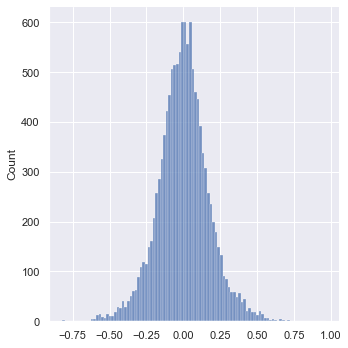

In [13]:
sns.displot(torch.cat((z_1, z_2), 0).flatten().detach().cpu().numpy())

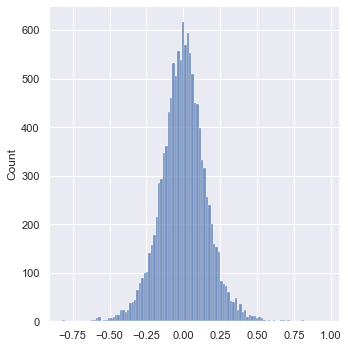

In [14]:
sns.displot(torch.cat((z_base_1, z_base_2), 0).flatten().detach().cpu().numpy())

(array([  3.,   5.,   6.,   7., 117., 425.,   7.,   3.,   5.,   6.]),
 array([-0.3950122 , -0.31679052, -0.23856887, -0.16034721, -0.08212554,
        -0.00390388,  0.07431778,  0.15253945,  0.23076111,  0.3089828 ,
         0.38720444], dtype=float32),
 <BarContainer object of 10 artists>)

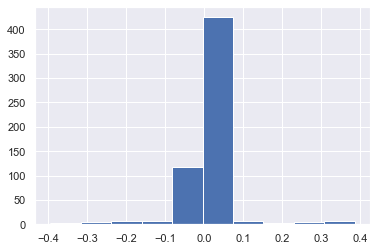

In [15]:
plt.hist(Vsp.Vspecies.weight.flatten().detach().cpu().numpy())

In [16]:
# torch.save(autoencoder_a375,'../results/my_results/vae_a375.pt')
# torch.save(autoencoder_ht29,'../results/my_results/vae_ht29.pt')
# #torch.save(decoder_a375,'../results/my_results/decoder_a375.pt')
# #torch.save(decoder_ht29,'../results/my_results/decoder_ht29.pt')

In [17]:
valPear = np.array(valPear)
valPearDirect = np.array(valPearDirect)
crossCorrelation = np.array(crossCorrelation)
valSpear = np.array(valSpear)
valAccuracy= np.array(valAccuracy)
valSpearDirect= np.array(valSpearDirect)
valAccDirect= np.array(valAccDirect)

In [18]:
print(np.mean(valPear,axis=0))
print(np.mean(valPearDirect))

[0.69996376 0.6449095 ]
0.45795060992240905


In [19]:
print(np.mean(valSpear,axis=0))
print(np.mean(valSpearDirect))

[0.60007563 0.56973341]
0.40821883215419613


In [20]:
print(np.mean(valAccuracy,axis=0))
print(np.mean(valAccDirect,axis=0))

[0.71015849 0.70111452]
[0.64107618 0.64107618]


In [21]:
print(np.mean(valF1))
print(np.mean(valClassAcc))

1.0
1.0


In [22]:
# print(np.mean(valPear,axis=0))
# print(np.mean(valPearMean,axis=0))
# print(np.mean(valPearUniform,axis=0))
# print(np.mean(valPearScrampled,axis=0))
# print(np.mean(valPearDirect))
# print(np.mean(crossCorrelation,axis=0))

In [23]:
df_result = pd.DataFrame({'F1_score':valF1,'ClassAccuracy':valClassAcc,
                          'model_pearsonHT29':valPear[:,0],'model_pearsonA375':valPear[:,1],
                          'model_spearHT29':valSpear[:,0],'model_spearA375':valSpear[:,1],
                          'model_accHT29':valAccuracy[:,0],'model_accA375':valAccuracy[:,1],
                          'recon_pear_ht29':valPear_2 ,'recon_pear_a375':valPear_1,
                          'recon_spear_ht29':valSpear_2 ,'recon_spear_a375':valSpear_1,
                          'recon_acc_ht29':valAccuracy_2 ,'recon_acc_a375':valAccuracy_1,
                          'Direct_pearson':valPearDirect,'Direct_spearman':valSpearDirect,
                          'DirectAcc_ht29':valAccDirect[:,0],'DirectAcc_a375':valAccDirect[:,1]})
df_result

,F1_score,ClassAccuracy,model_pearsonHT29,model_pearsonA375,model_spearHT29,model_spearA375,model_accHT29,model_accA375,recon_pear_ht29,recon_pear_a375,recon_spear_ht29,recon_spear_a375,recon_acc_ht29,recon_acc_a375,Direct_pearson,Direct_spearman,DirectAcc_ht29,DirectAcc_a375
0,1.0,1.0,0.748481,0.673342,0.662073,0.604682,0.732797,0.717510,0.831326,0.806153,0.777427,0.737934,0.797825,0.777215,0.520686,0.463031,0.662730,0.662730
1,1.0,1.0,0.695696,0.672138,0.581036,0.566982,0.702531,0.702556,0.816990,0.789868,0.750484,0.704539,0.786057,0.764375,0.479417,0.420304,0.649847,0.649847
2,1.0,1.0,0.764636,0.730406,0.661859,0.647950,0.730573,0.731161,0.790620,0.815008,0.726577,0.746654,0.770840,0.779772,0.500422,0.432608,0.644836,0.644836
3,1.0,1.0,0.718573,0.669254,0.604124,0.574181,0.717101,0.704525,0.812668,0.803064,0.743098,0.722154,0.782515,0.772435,0.445524,0.393393,0.635890,0.635890
4,1.0,1.0,0.746797,0.698562,0.627261,0.613357,0.720118,0.712193,0.835958,0.811065,0.781110,0.734417,0.805763,0.776593,0.542872,0.442503,0.653144,0.653144
5,1.0,1.0,0.680350,0.637008,0.608584,0.559457,0.722060,0.697137,0.831959,0.811053,0.773386,0.745494,0.804025,0.785063,0.456026,0.433163,0.654525,0.654525
6,1.0,1.0,0.664518,0.576398,0.564026,0.518973,0.694606,0.680368,0.828790,0.789486,0.771446,0.722204,0.800065,0.771881,0.391251,0.353916,0.618405,0.618405
7,1.0,1.0,0.710810,0.625737,0.641991,0.584657,0.726253,0.708180,0.836766,0.767657,0.780334,0.693412,0.808310,0.759356,0.455651,0.433182,0.652428,0.652428
8,1.0,1.0,0.629094,0.566340,0.498267,0.479480,0.667766,0.661529,0.796626,0.792136,0.735875,0.735458,0.779002,0.780240,0.373686,0.337688,0.610148,0.610148
9,1.0,1.0,0.640684,0.599909,0.551536,0.547615,0.687781,0.695987,0.808007,0.785308,0.747484,0.735733,0.782590,0.779047,0.413972,0.372399,0.628809,0.628809


In [24]:
df_result.to_csv('../results/MI_results/landmarks_10foldvalidation_withCPA_1000ep512bs_a375_ht29_v3.csv')

## Evaluate embeddings

In [ ]:
for i in range(10):
    # Network
    encoder_1 = torch.load('../results/MI_results/models/CPA_approach/encoder_a375v3_%s.pt'%i)
    encoder_2 = torch.load('../results/MI_results/models/CPA_approach/encoder_ht29v3_%s.pt'%i)
    Vsp = torch.load('../results/MI_results/models/CPA_approach/Vspecies3_%s.pt'%i)
    
    #autoencoder_a375 = torch.load('../results/my_results/models/notvae/autoencoder_mmd_a375_%s.pt'%i)
    #autoencoder_ht29 = torch.load('../results/my_results/models/notvae/autoencoder_mmd_ht29_%s.pt'%i)
    
    trainInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_paired_%s.csv'%i,index_col=0)
    trainInfo_1 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_a375_%s.csv'%i,index_col=0)
    trainInfo_2 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_ht29_%s.csv'%i,index_col=0)
    
    valInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_paired_%s.csv'%i,index_col=0)
    valInfo_1 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_a375_%s.csv'%i,index_col=0)
    valInfo_2 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_ht29_%s.csv'%i,index_col=0)
    
    encoder_1.eval()
    encoder_2.eval()
    Vsp.eval()
    #autoencoder_a375.eval()
    #autoencoder_ht29.eval()
    
    paired_val_inds = len(valInfo_paired)
    x_1 = torch.tensor(np.concatenate((cmap.loc[valInfo_paired['sig_id.x']].values,
                                          cmap.loc[valInfo_1.sig_id].values))).float().to(device)
    x_2 = torch.tensor(np.concatenate((cmap.loc[valInfo_paired['sig_id.y']].values,
                                          cmap.loc[valInfo_2.sig_id].values))).float().to(device)
    
    z_base_1 = encoder_1(x_1)
    z_base_2 = encoder_2(x_2)
    
    z_species_1 = torch.cat((torch.ones(x_1.shape[0],1),
                             torch.zeros(x_1.shape[0],1)),1).to(device)
    z_species_2 = torch.cat((torch.zeros(x_2.shape[0],1),
                             torch.ones(x_2.shape[0],1)),1).to(device)
    
    z_latent_1 = Vsp(z_base_1,z_species_1)
    z_latent_2 = Vsp(z_base_2,z_species_2)
    
    valEmbs_1 = pd.DataFrame(z_latent_1.detach().cpu().numpy())
    valEmbs_1.index = np.concatenate((valInfo_paired['sig_id.x'].values,valInfo_1.sig_id.values))
    valEmbs_2 = pd.DataFrame(z_latent_2.detach().cpu().numpy())
    valEmbs_2.index = np.concatenate((valInfo_paired['sig_id.y'].values,valInfo_2.sig_id.values))
    
    valEmbs_base_1 = pd.DataFrame(z_base_1.detach().cpu().numpy())
    valEmbs_base_1.index = np.concatenate((valInfo_paired['sig_id.x'].values,valInfo_1.sig_id.values))
    valEmbs_base_2 = pd.DataFrame(z_base_2.detach().cpu().numpy())
    valEmbs_base_2.index = np.concatenate((valInfo_paired['sig_id.y'].values,valInfo_2.sig_id.values))
    
    # Training embeddigns
    paired_inds = len(trainInfo_paired)
    x_1 = torch.tensor(np.concatenate((cmap.loc[trainInfo_paired['sig_id.x']].values,
                                          cmap.loc[trainInfo_1.sig_id].values))).float().to(device)
    x_2 = torch.tensor(np.concatenate((cmap.loc[trainInfo_paired['sig_id.y']].values,
                                          cmap.loc[trainInfo_2.sig_id].values))).float().to(device)
    z_base_1 = encoder_1(x_1)
    z_base_2 = encoder_2(x_2)
    
    z_species_1 = torch.cat((torch.ones(x_1.shape[0],1),
                             torch.zeros(x_1.shape[0],1)),1).to(device)
    z_species_2 = torch.cat((torch.zeros(x_2.shape[0],1),
                             torch.ones(x_2.shape[0],1)),1).to(device)
    
    z_latent_1 = Vsp(z_base_1,z_species_1)
    z_latent_2 = Vsp(z_base_2,z_species_2)
    
    trainEmbs_1 = pd.DataFrame(z_latent_1.detach().cpu().numpy())
    trainEmbs_1.index = np.concatenate((trainInfo_paired['sig_id.x'].values,trainInfo_1.sig_id.values))
    trainEmbs_2 = pd.DataFrame(z_latent_2.detach().cpu().numpy())
    trainEmbs_2.index = np.concatenate((trainInfo_paired['sig_id.y'].values,trainInfo_2.sig_id.values))
    
    trainEmbs_base_1 = pd.DataFrame(z_base_1.detach().cpu().numpy())
    trainEmbs_base_1.index = np.concatenate((trainInfo_paired['sig_id.x'].values,trainInfo_1.sig_id.values))
    trainEmbs_base_2 = pd.DataFrame(z_base_2.detach().cpu().numpy())
    trainEmbs_base_2.index = np.concatenate((trainInfo_paired['sig_id.y'].values,trainInfo_2.sig_id.values))
    
    valEmbs_1.to_csv('../results/MI_results/embs/CPA_approach/validation/valEmbsv3_%s_a375.csv'%i)
    valEmbs_2.to_csv('../results/MI_results/embs/CPA_approach/validation/valEmbsv3_%s_ht29.csv'%i)
    trainEmbs_1.to_csv('../results/MI_results/embs/CPA_approach/train/trainEmbsv3_%s_a375.csv'%i)
    trainEmbs_2.to_csv('../results/MI_results/embs/CPA_approach/train/trainEmbsv3_%s_ht29.csv'%i)
    
    valEmbs_base_1.to_csv('../results/MI_results/embs/CPA_approach/validation/valEmbs_basev3_%s_a375.csv'%i)
    valEmbs_base_2.to_csv('../results/MI_results/embs/CPA_approach/validation/valEmbs_basev3_%s_ht29.csv'%i)
    trainEmbs_base_1.to_csv('../results/MI_results/embs/CPA_approach/train/trainEmbs_basev3_%s_a375.csv'%i)
    trainEmbs_base_2.to_csv('../results/MI_results/embs/CPA_approach/train/trainEmbs_basev3_%s_ht29.csv'%i)

## Train on all data

In [26]:
# NUM_EPOCHS = 1000
# #bs = 512
# bs_a375 = 178
# bs_ht29 = 154
# bs_paired = 90
# bs_paired_ctrl = 1000
# beta=1.0

In [27]:
# valR2 = []
# valPear = []
# valMSE =[]
# valSpear = []
# valAccuracy = []

# valPear_ctrl = []
# valSpear_ctrl = []
# valAccuracy_ctrl = []


# valPearDirect = []
# valSpearDirect = []
# valAccDirect = []

# valR2_a375 = []
# valPear_a375 = []
# valMSE_a375 =[]
# valSpear_a375 = []
# valAccuracy_a375 = []
# valPear_ctrl_a375 = []
# valSpear_ctrl_a375 = []
# valAccuracy_ctrl_a375 = []

# valR2_ht29 = []
# valPear_ht29 = []
# valMSE_ht29 =[]
# valSpear_ht29 = []
# valAccuracy_ht29 = []
# valPear_ctrl_ht29 = []
# valSpear_ctrl_ht29 = []
# valAccuracy_ctrl_ht29 = []

# crossCorrelation = []

# #model_mi.eval()
# #trainLoss = []
# for i in range(1):
#     # Network
#     decoder_a375 = Decoder(292,[384,640],gene_size,dropRate=0.2, activation=torch.nn.ELU()).to(device)
#     decoder_ht29 = Decoder(292,[384,640],gene_size,dropRate=0.2, activation=torch.nn.ELU()).to(device)
    
#     # Infomax
#     #master_encoder = SimpleEncoder(gene_size,[640,384],292,dropRate=0.1, activation=torch.nn.ELU())#.to(device)
#     encoder_a375 = SimpleEncoder(gene_size,[640,384],292,dropRate=0.1, activation=torch.nn.ELU()).to(device)
#     encoder_ht29 = SimpleEncoder(gene_size,[640,384],292,dropRate=0.1, activation=torch.nn.ELU()).to(device)
#     prior_d = PriorDiscriminator(292).to(device)
#     local_d = LocalDiscriminator(292,292).to(device)
#     #model = EmbInfomax(292,master_encoder)
    
#     #model = MultiEncInfomax(292,[encoder_a375,encoder_ht29])    
#     #model = model.to(device)
    
#     #encoder_a375.load_state_dict(model_mi.encoder.state_dict())
#     #encoder_ht29.load_state_dict(model_mi.encoder.state_dict())
#     #model.encoders[0].load_state_dict(model_mi.encoder.state_dict())
#     #model.encoders[1].load_state_dict(model_mi.encoder.state_dict())
#     #local_d.load_state_dict(model_mi.local_d.state_dict())
#     #prior_d.load_state_dict(model_mi.prior_d.state_dict())
#     #model.load_state_dict(model_mi.state_dict())
#     #master_encoder.load_state_dict(model_mi.encoder.state_dict())
    
#     #autoencoder_a375.load_state_dict(master_autoencoder.state_dict())
#     #autoencoder_ht29.load_state_dict(master_autoencoder.state_dict())
#     #encoder_a375 = Encoder(gene_size,[4096,2048],1024,dropRate=0.1, activation=torch.nn.ELU())
#     #decoder_a375 = Decoder(1024,[2048,4096],gene_size,dropRate=0.1, activation=torch.nn.ELU())
#     #autoencoder_a375 = VAE(encoder_a375,decoder_a375,device).to(device)
    
#     #encoder_ht29 = Encoder(gene_size,[4096,2048],1024,dropRate=0.1, activation=torch.nn.ELU())
#     #decoder_ht29 = Decoder(1024,[2048,4096],gene_size,dropRate=0.1, activation=torch.nn.ELU())
#     #autoencoder_ht29 = VAE(encoder_ht29,decoder_ht29,device).to(device)
    
#     trainInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/alldata/paired_pc3_ha1e.csv',index_col=0)
#     trainInfo_a375 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/alldata/pc3_unpaired.csv',index_col=0)
#     trainInfo_ht29 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/alldata/ha1e_unpaired.csv',index_col=0)
    
    
    
#     N_paired = len(trainInfo_paired)
#     N_a375 = len(trainInfo_a375)
#     N_ht29 = len(trainInfo_ht29)
#     N = N_a375
#     if N_ht29>N:
#         N=N_ht29
    
#     #cmap_train = cmap.loc[trainInfo.sig_id,:]
#     #cmap_val = cmap.loc[valInfo.sig_id,:]
#     #xtrain = torch.tensor(cmap_train.values).float().to(device)
#     #xval = torch.tensor(cmap_val.values).float().to(device)
    
#     #allParams = list(master_encoder.parameters()) +list(decoder_a375.parameters()) + list(decoder_ht29.parameters())
#     #allParams = list(model.parameters())+list(decoder_a375.parameters()) +list(decoder_ht29.parameters())
#     allParams = list(decoder_a375.parameters()) +list(decoder_ht29.parameters())
#     allParams = allParams + list(encoder_a375.parameters()) +list(encoder_ht29.parameters())
#     allParams = allParams + list(prior_d.parameters()) + list(local_d.parameters())
#     optimizer = torch.optim.Adam(allParams, lr= 0.001, weight_decay=0)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=300,gamma=0.8)
    
#     for e in range(0, NUM_EPOCHS):
#         decoder_a375.train()
#         decoder_ht29.train()
#         encoder_a375.train()
#         encoder_ht29.train()
#         prior_d.train()
#         local_d.train()
#         #model.train()
#         #master_encoder.train()
        
#         trainloader_a375 = getSamples(N_a375, bs_a375)
#         len_a375 = len(trainloader_a375)
#         trainloader_ht29 = getSamples(N_ht29, bs_ht29)
#         len_ht29 = len(trainloader_ht29)
#         trainloader_paired = getSamples(N_paired, bs_paired)
#         len_paired = len(trainloader_paired)

#         lens = [len_a375,len_ht29,len_paired]
#         maxLen = np.max(lens)

#         if maxLen>lens[0]:
#             while maxLen>len(trainloader_a375):
#                 trainloader_suppl = getSamples(N_a375, bs_a375)
#                 trainloader_a375 = trainloader_a375 + trainloader_suppl
        
#         if maxLen>lens[1]:
#             while maxLen>len(trainloader_ht29):
#                 trainloader_suppl = getSamples(N_ht29, bs_ht29)
#                 trainloader_ht29 = trainloader_ht29 + trainloader_suppl
        
#         if maxLen>lens[2]:
#             while maxLen>len(trainloader_paired):
#                 trainloader_suppl = getSamples(N_paired, bs_paired)
#                 trainloader_paired = trainloader_paired + trainloader_suppl
        
#         for j in range(maxLen):
#             dataIndex_a375 = trainloader_a375[j]
#             dataIndex_ht29 = trainloader_ht29[j]
#             dataIndex_paired = trainloader_paired[j]
            
#             df_pairs = trainInfo_paired.iloc[dataIndex_paired,:]
#             df_a375 = trainInfo_a375.iloc[dataIndex_a375,:]
#             df_ht29 = trainInfo_ht29.iloc[dataIndex_ht29,:]
#             paired_inds = len(df_pairs)
            
#             a375_inds = len(df_a375) + paired_inds
            
            
#             X_a375 = torch.tensor(np.concatenate((cmap.loc[df_pairs['sig_id.x']].values,
#                                                  cmap.loc[df_a375.sig_id].values))).float().to(device)
#             X_ht29 = torch.tensor(np.concatenate((cmap.loc[df_pairs['sig_id.y']].values,
#                                                  cmap.loc[df_ht29.sig_id].values))).float().to(device)
            
#             conditions = np.concatenate((df_pairs.conditionId.values,
#                                          df_a375.conditionId.values,
#                                          df_pairs.conditionId.values,
#                                          df_ht29.conditionId.values))
            
#             size = conditions.size
#             conditions = conditions.reshape(size,1)
#             conditions = conditions == conditions.transpose()
#             conditions = conditions*1
#             mask = torch.tensor(conditions).to(device).detach()
#             pos_mask = mask
#             neg_mask = 1 - mask
#             log_2 = math.log(2.)
#             optimizer.zero_grad()
            
#             z_a375 = encoder_a375(X_a375)
#             z_ht29 = encoder_ht29(X_ht29)
            
#             z_un = local_d(torch.cat((z_a375, z_ht29), 0))
#             res_un = torch.matmul(z_un, z_un.t())
            
#             y_pred_a375 = decoder_a375(z_a375)
#             fitLoss_a375 = torch.mean(torch.sum((y_pred_a375 - X_a375)**2,dim=1))
#             L2Loss_a375 = decoder_a375.L2Regularization(0.01) + encoder_a375.L2Regularization(0.01)
#             loss_a375 = fitLoss_a375 + L2Loss_a375
            
#             y_pred_ht29 = decoder_ht29(z_ht29)
#             fitLoss_ht29 = torch.mean(torch.sum((y_pred_ht29 - X_ht29)**2,dim=1))
#             L2Loss_ht29 = decoder_ht29.L2Regularization(0.01) + encoder_ht29.L2Regularization(0.01)
#             loss_ht29 = fitLoss_ht29 + L2Loss_ht29
            
#             #modelL2 = model.L2Regularization(0.01)
#             silimalityLoss = torch.mean(torch.sum((z_a375[0:paired_inds ,:] - z_ht29[0:paired_inds,:])**2,dim=-1))
            
#             p_samples = res_un * pos_mask
#             q_samples = res_un * neg_mask

#             Ep = log_2 - F.softplus(- p_samples)
#             Eq = F.softplus(-q_samples) + q_samples - log_2

#             Ep = (Ep * pos_mask).sum() / pos_mask.sum()
#             Eq = (Eq * neg_mask).sum() / neg_mask.sum()
#             mi_loss = Eq - Ep

#             prior = torch.rand_like(torch.cat((z_a375, z_ht29), 0))

#             term_a = torch.log(prior_d(prior)).mean()
#             term_b = torch.log(1.0 - prior_d(torch.cat((z_a375, z_ht29), 0))).mean()
#             prior_loss = -(term_a + term_b) * beta
            
#             #Direct translate
#             #x_a375_translated = decoder_a375(z_ht29[0:paired_inds,:])
#             #x_ht29_translated = decoder_ht29(z_a375[0:paired_inds,:])
#             #directLoss = torch.mean(torch.sum((x_a375_translated - X_a375[0:paired_inds,:])**2,dim=1)) + torch.mean(torch.sum((x_ht29_translated - X_ht29[0:paired_inds,:])**2,dim=1))
        
#             #ZeroEmbPenalnty = 1e-7*torch.sum(1 - torch.abs(z_latent))
#             #LossCtrl = torch.mean(torch.sum(torch.abs(z_a375[paired_inds:paired_ctrl_inds,:]),dim=-1))
#             #LossCtrl = LossCtrl + torch.mean(torch.sum(torch.abs(z_ht29[paired_inds:paired_ctrl_inds,:]),dim=-1))
#             loss = loss_a375 + loss_ht29 + mi_loss + prior_loss + silimalityLoss #+ LossCtrl#modelL2 
#             #loss = loss_a375 + loss_ht29 + directLoss

#             loss.backward()

#             optimizer.step()
        
#             pearson_a375 = pearson_r(y_pred_a375.detach().flatten(), X_a375.detach().flatten())
#             r2_a375 = r_square(y_pred_a375.detach().flatten(), X_a375.detach().flatten())
#             mse_a375 = torch.mean(torch.mean((y_pred_a375.detach() - X_a375.detach())**2,dim=1))
        
#             pearson_ht29 = pearson_r(y_pred_ht29.detach().flatten(), X_ht29.detach().flatten())
#             r2_ht29 = r_square(y_pred_ht29.detach().flatten(), X_ht29.detach().flatten())
#             mse_ht29 = torch.mean(torch.mean((y_pred_ht29.detach() - X_ht29.detach())**2,dim=1))            
            
#         scheduler.step()
#         outString = 'Split {:.0f}: Epoch={:.0f}/{:.0f}'.format(i+1,e+1,NUM_EPOCHS)
#         outString += ', r2_a375={:.4f}'.format(r2_a375.item())
#         outString += ', pearson_a375={:.4f}'.format(pearson_a375.item())
#         outString += ', MSE_a375={:.4f}'.format(mse_a375.item())
#         outString += ', r2_ht29={:.4f}'.format(r2_ht29.item())
#         outString += ', pearson_ht29={:.4f}'.format(pearson_ht29.item())
#         outString += ', MSE_ht29={:.4f}'.format(mse_ht29.item())
#         outString += ', MI Loss={:.4f}'.format(mi_loss.item())
#         outString += ', Prior Loss={:.4f}'.format(prior_loss.item())
#         outString += ', loss={:.4f}'.format(loss.item())
#         if (e%250==0):
#             print(outString)
#     print(outString)
#     #trainLoss.append(splitLoss)
#     decoder_a375.eval()
#     decoder_ht29.eval()
#     encoder_a375.eval()
#     encoder_ht29.eval()
#     prior_d.eval()
#     local_d.eval()
    
#     torch.save(decoder_a375,'../results/MI_results/models/AllData_Model/decoder_pc3.pt')
#     torch.save(decoder_ht29,'../results/MI_results/models/AllData_Model/decoder_ha1e.pt')
#     torch.save(prior_d,'../results/MI_results/models/AllData_Model/priorDiscr.pt')
#     torch.save(local_d,'../results/MI_results/models/AllData_Model/localDiscr.pt')
#     torch.save(encoder_a375,'../results/MI_results/models/AllData_Model/encoder_pc3.pt')
#     torch.save(encoder_ht29,'../results/MI_results/models/AllData_Model/encoder_ha1e.pt')